In [1]:
from scipy.integrate import ode
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, initializers
from sklearn.preprocessing import MinMaxScaler
from time import time
from os import path

In [2]:
def lorenz(t, y, params):
    """
    Diferencialne enacbe Lorentzovega modela
    y = [x,y,z]
    dy = [dx/dt, dy/dt, dz/dt]
    params=[sigma,rho,beta]
    """
    dy=np.zeros(3)
    dy[0]=params[0]*(y[1]-y[0])
    dy[1]=(params[1]-y[2])*y[0] - y[1]
    dy[2]=y[0]*y[1] - params[2]*y[2]
    return dy

### Integracija Lorenzovega sistema v času ###

# definiarmo vrenosti parametrov params=[sigma,rho,beta]
params = [10., 28.,8./3.]

#nastavimo zacetni cas na 0
t = 0.
#dolzina casovnega koraka
dt=0.01

#koncni cas integracije
tmax=10000.

#Dolocimo vrednosti spremenljivk x,y, ob casu 0;
#nakljucne vrednosti so zrebane po enakomerni porazdelitvi
y0_ATM = np.array([np.random.uniform(-20,20),np.random.uniform(-20,20),np.random.uniform(10,30)])

# nasa njboljsa ocena trenutnega stanja ozracja ima napako
c=0.2
y0_MOD=y0_ATM + c*np.random.random(3)

#nastavimo integrator
solver_ATM=ode(lorenz).set_integrator('dopri5')
solver_ATM.set_f_params(params)
solver_ATM.set_initial_value(y0_ATM, t)

solver_MOD=ode(lorenz).set_integrator('dopri5')
solver_MOD.set_f_params(params)
solver_MOD.set_initial_value(y0_ATM, t)

In [3]:
if(path.exists("data/data-2.npy") != 1):
    print("Generating data.")
    n = int(tmax/dt) + 1
    data = np.zeros((n, 3))

    i = 0
    start = time()
    while t < tmax:
        y_ATM = solver_ATM.integrate(t+dt)
        #y0_MOD = solver_MOD.integrate(t+dt)
        data[i, :] = y_ATM[:]
        i = i + 1
        t += dt
    print("Elasped time: %0.3g s" %(time()-start))
    data = data[1000:] # only use data from the attractor (after time = 10000 * dt)
    print("Integration finished.")
    np.save("data/data-2.npy", data)
    
else:
    print("Data exist.")
    data = np.load("data/data-2.npy")
    print("Data loaded.")

Data exist.
Data loaded.


In [4]:
#PREPROCESS DATA
x_train = data[:-1,:]
y_train = data[1:, :] - data[:-1, :]

x_scaler=MinMaxScaler()
y_scaler=MinMaxScaler()

x_scaler.fit(x_train)
y_scaler.fit(y_train)

x_train_norm=x_scaler.transform(x_train)
y_train_norm=y_scaler.transform(y_train)

xy_train_norm=np.concatenate((x_train_norm,y_train_norm), axis=1)

new_order=np.random.choice(range(x_train.shape[0]),x_train.shape[0],replace=False)
x_train_norm=x_train_norm[new_order]
y_train_norm=y_train_norm[new_order]

In [5]:
from tensorflow.keras.layers import Dense, Dropout
# create a "Sequential" model and add a Dense layer as the first layer
# ce nasa Loss ne vec pade se ustavi minimizacija
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='min')

#initializer = 
#ce dosezemo plato zmanjsamo korak ucenja
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=0.0001)

model = tf.keras.models.Sequential()
model.add(Dense(3, input_dim=3, activation='relu'))
model.add(Dense(81, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(81, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(81, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(81, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(3, activation='sigmoid'))

model.compile(loss='mean_absolute_error', optimizer='Adam', metrics=['mae'])

In [7]:
# Train model on data
start=time()
history = model.fit(x_train_norm, y_train_norm, epochs=200, batch_size=1024,validation_split=0.2,
                    callbacks=[callback,reduce_lr])
print("Elasped time: %0.3g s" %(time()-start))
print(model.summary())

Epoch 1/200
781/781 [==============================] - 3s 3ms/step - loss: 0.0233 - mae: 0.0233 - val_loss: 0.0092 - val_mae: 0.0092
Epoch 2/200
781/781 [==============================] - 2s 3ms/step - loss: 0.0078 - mae: 0.0078 - val_loss: 0.0040 - val_mae: 0.0040
Epoch 3/200
781/781 [==============================] - 2s 3ms/step - loss: 0.0030 - mae: 0.0030 - val_loss: 0.0042 - val_mae: 0.0042
Epoch 4/200
781/781 [==============================] - 2s 3ms/step - loss: 0.0025 - mae: 0.0025 - val_loss: 0.0028 - val_mae: 0.0028
Epoch 5/200
781/781 [==============================] - 3s 3ms/step - loss: 0.0020 - mae: 0.0020 - val_loss: 0.0016 - val_mae: 0.0016
Epoch 6/200
781/781 [==============================] - 2s 3ms/step - loss: 0.0020 - mae: 0.0020 - val_loss: 0.0027 - val_mae: 0.0027
Epoch 7/200
781/781 [==============================] - 2s 3ms/step - loss: 0.0018 - mae: 0.0018 - val_loss: 0.0023 - val_mae: 0.0023
Epoch 8/200
781/781 [==============================] - 2s 3ms/step - 

781/781 [==============================] - 2s 3ms/step - loss: 7.8267e-04 - mae: 7.8267e-04 - val_loss: 8.5437e-04 - val_mae: 8.5437e-04
Epoch 61/200
781/781 [==============================] - 2s 3ms/step - loss: 8.4569e-04 - mae: 8.4569e-04 - val_loss: 9.0645e-04 - val_mae: 9.0645e-04
Epoch 62/200
781/781 [==============================] - 2s 3ms/step - loss: 8.6951e-04 - mae: 8.6951e-04 - val_loss: 7.3568e-04 - val_mae: 7.3568e-04
Epoch 63/200
781/781 [==============================] - 2s 3ms/step - loss: 7.5163e-04 - mae: 7.5163e-04 - val_loss: 7.5642e-04 - val_mae: 7.5642e-04
Epoch 64/200
781/781 [==============================] - 2s 3ms/step - loss: 8.3373e-04 - mae: 8.3373e-04 - val_loss: 0.0011 - val_mae: 0.0011
Epoch 65/200
781/781 [==============================] - 2s 3ms/step - loss: 8.4376e-04 - mae: 8.4376e-04 - val_loss: 9.5694e-04 - val_mae: 9.5694e-04
Epoch 66/200
781/781 [==============================] - 2s 3ms/step - loss: 7.4326e-04 - mae: 7.4326e-04 - val_loss: 7.20

781/781 [==============================] - 2s 3ms/step - loss: 6.3940e-04 - mae: 6.3940e-04 - val_loss: 6.3385e-04 - val_mae: 6.3385e-04
Epoch 115/200
781/781 [==============================] - 2s 3ms/step - loss: 6.4264e-04 - mae: 6.4264e-04 - val_loss: 6.3380e-04 - val_mae: 6.3380e-04
Epoch 116/200
781/781 [==============================] - 2s 3ms/step - loss: 6.4097e-04 - mae: 6.4097e-04 - val_loss: 6.3663e-04 - val_mae: 6.3663e-04
Epoch 117/200
781/781 [==============================] - 3s 4ms/step - loss: 6.3721e-04 - mae: 6.3721e-04 - val_loss: 6.2172e-04 - val_mae: 6.2172e-04
Epoch 118/200
781/781 [==============================] - 3s 3ms/step - loss: 6.3494e-04 - mae: 6.3494e-04 - val_loss: 6.2022e-04 - val_mae: 6.2022e-04
Epoch 119/200
781/781 [==============================] - 3s 3ms/step - loss: 6.3962e-04 - mae: 6.3962e-04 - val_loss: 6.3935e-04 - val_mae: 6.3935e-04
Epoch 120/200
781/781 [==============================] - 3s 3ms/step - loss: 6.3621e-04 - mae: 6.3621e-04 - 

781/781 [==============================] - 2s 3ms/step - loss: 6.0917e-04 - mae: 6.0917e-04 - val_loss: 6.0037e-04 - val_mae: 6.0037e-04
Epoch 169/200
781/781 [==============================] - 2s 3ms/step - loss: 6.0950e-04 - mae: 6.0950e-04 - val_loss: 5.9103e-04 - val_mae: 5.9103e-04
Epoch 170/200
781/781 [==============================] - 2s 3ms/step - loss: 6.0704e-04 - mae: 6.0704e-04 - val_loss: 5.9144e-04 - val_mae: 5.9144e-04
Epoch 171/200
781/781 [==============================] - 3s 3ms/step - loss: 6.1212e-04 - mae: 6.1212e-04 - val_loss: 6.2688e-04 - val_mae: 6.2688e-04
Epoch 172/200
781/781 [==============================] - 2s 3ms/step - loss: 6.0776e-04 - mae: 6.0776e-04 - val_loss: 5.9931e-04 - val_mae: 5.9931e-04
Epoch 173/200
781/781 [==============================] - 2s 3ms/step - loss: 6.0757e-04 - mae: 6.0757e-04 - val_loss: 5.9082e-04 - val_mae: 5.9082e-04
Epoch 174/200
781/781 [==============================] - 2s 3ms/step - loss: 6.0777e-04 - mae: 6.0777e-04 - 

In [9]:
# Save weights to file
#model.save_weights("model.h5")
# load weights into model
model.load_weights("model.h5")

In [14]:
from utils import moving_average

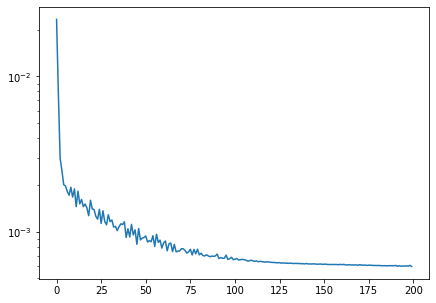

In [10]:
plt.figure(figsize=(7,5))
plt.plot(history.history['loss'])
plt.yscale('log')

In [11]:
# Integriramo
tmax = 10
n = int(tmax/dt)+1
data_lorenz_NN = np.zeros((n,3))
data_lorenz_IN = np.zeros((n,3))

# define new IC
t=0
i=0

#izberemo zacetni pogoj nekje na atraktorju
y0=data[int(np.random.uniform(1000,data.shape[0]))]

#definiramo parametre Lorenzovega modela
params = [10., 28., 8./3.]

# definiramo ODE solver
solver_ATM = ode(lorenz).set_integrator('dopri5')
solver_ATM.set_f_params(params)
solver_ATM.set_initial_value(y0_ATM, t)
solver_ATM.set_initial_value(y0, t)

data_lorenz_IN[0, :]= y0
data_lorenz_NN[0, :]= y0

i=1
t=dt

print("Calculating...")
start = time()
while t < tmax:      
    y_ATM = solver_ATM.integrate(t+dt)
    data_lorenz_IN[i,:] = y_ATM[:]
    
    norm_input=x_scaler.transform(np.array([data_lorenz_NN[i-1,:]]))
    norm_output=model.predict(norm_input)
    
    add=y_scaler.inverse_transform(norm_output)
    data_lorenz_NN[i,:]=add[0] + data_lorenz_NN[i-1,:]
    
    i = i + 1
    t = t+dt
print("Finished in %.3g" %(time()-start))

Calculating...
Finished in 28.2


In [56]:
data_lorenz_IN[0, :]

array([ 1.1581981 ,  0.0447786 , 21.22847328])

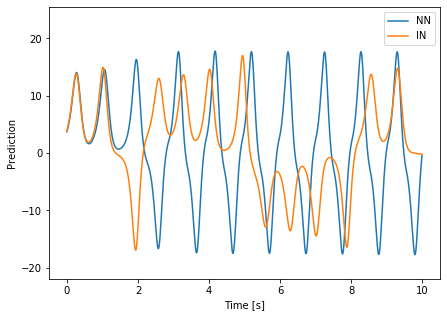

In [12]:
idx=0
plt.figure(figsize=(7,5))
plt.plot(np.arange(0, tmax+dt,dt), data_lorenz_NN[:,idx], label='NN')
plt.plot(np.arange(0, tmax+dt,dt), data_lorenz_IN[:,idx], label='IN')
plt.legend()
plt.ylabel("Prediction")
plt.xlabel("Time [s]")
plt.ylim(min(data_lorenz_IN[:, idx]) - 5, max(data_lorenz_IN[:, idx]) * 1.5)
plt.show()

In [13]:
"""plt.figure(figsize=(7.5, 4.5))
plt.plot(history.history['loss'], label='train',alpha=0.2)
plt.plot(moving_average(history.history['loss'], 40)[1], label='train, ma=40')
plt.plot(history.history['val_loss'], label='val')
plt.plot(moving_average(history.history['val_loss'], 40)[1], label='val, ma=40')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
#plt.ylim([0, 0.005])
plt.yscale('log')
plt.show()"""

"plt.figure(figsize=(7.5, 4.5))\nplt.plot(history.history['loss'], label='train',alpha=0.2)\nplt.plot(moving_average(history.history['loss'], 40)[1], label='train, ma=40')\nplt.plot(history.history['val_loss'], label='val')\nplt.plot(moving_average(history.history['val_loss'], 40)[1], label='val, ma=40')\nplt.xlabel('epoch')\nplt.ylabel('Loss')\nplt.legend()\nplt.tight_layout()\n#plt.ylim([0, 0.005])\nplt.yscale('log')\nplt.show()"